# Direct Access to MUR 1-km in S3 + Analysis

In [1]:
import s3fs
import requests
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import netCDF4
from json import dumps
from io import StringIO
from os.path import dirname, join
from IPython.display import HTML

In [2]:
ShortName = "MUR-JPL-L4-GLOB-v4.1"

### Earthdata Login

You should have a .netrc file in your home directory set up like:

    machine urs.earthdata.nasa.gov 
    login <username> 
    password <password>

### Direct Access to Data from S3

In [3]:
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

s3fs.core.S3FileSystem

### Dataset

In [11]:
mur_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, "*2015*.nc"))

len(mur_files)

365

In [12]:
mur_files

['podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150103090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150104090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150105090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150106090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150107090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150108090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150109090000-JPL-L4_GHRSST

In [13]:
# mur_files = mur_files[0:31]

In [14]:
variables=[
    'analysed_sst', 
    'mask'
]

def subset(ds):
    subset_ds = ds[variables].sel(
        lat=slice(18, 25),
        lon=slice(-160, -150)
    )
    return subset_ds

In [15]:
mur_Dataset = xr.open_mfdataset(
    paths=[fs.open(f) for f in mur_files],
    preprocess=subset,
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
    cache=False,
    engine='h5netcdf',
    chunks='auto'
)

mur_Dataset

<xarray.Dataset>
Dimensions:       (time: 365, lat: 701, lon: 1001)
Coordinates:
  * time          (time) datetime64[ns] 2015-01-01T09:00:00 ... 2015-12-31T09...
  * lat           (lat) float32 18.0 18.01 18.02 18.03 ... 24.98 24.99 25.0
  * lon           (lon) float32 -160.0 -160.0 -160.0 ... -150.0 -150.0 -150.0
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 383, 1001), meta=np.ndarray>
    mask          (time, lat, lon) float32 dask.array<chunksize=(1, 383, 1001), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

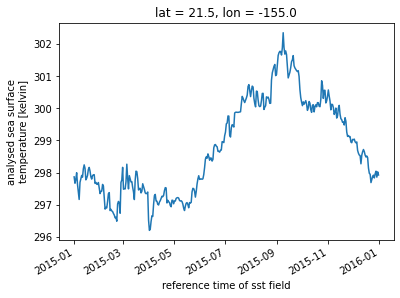

In [16]:
mur_Dataset['analysed_sst'].isel(lat=350, lon=500).plot()

In [17]:
mur_Dataset['analysed_sst'].isel(lat=10000, lon=1000).plot()

IndexError: Index is not smaller than dimension 10000 >= 701

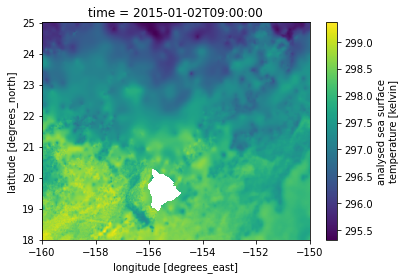

In [18]:
mur_Dataset['analysed_sst'].isel(time=1).plot()

In [12]:
def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xr.open_dataset(fs.open(path)) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            ds.load()
            return ds

#     paths = sorted(fs.glob(files))
    paths = files
    print(files)
    datasets = [process_one_path(p) for p in paths]
    print(datasets)
    combined = xr.concat(datasets, dim)
    return combined

In [ ]:
combined = read_netcdfs(mur_Files, dim='time',
                        transform_func=subset)

['podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150103090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150104090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150105090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150106090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150107090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150108090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150109090000-JPL-L4_GHRSST-SSTfnd-

In [ ]:
combined